In [1]:
import simulation_settings as ss
import ship as ship
import constants
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import glob
import driver
import time
import datetime

In [2]:
gg = constants.gg
rho = constants.rho
beta = constants.beta
dt = constants.dt

In [30]:
#reset variables
if('ww' in globals()):del ww
if('pp' in globals()):del pp
if('dd' in globals()):del dd

In [31]:
#create environment JONSWAP(num_waves, T_1, H_third)
T_1 = 2.8
H_3 = 0.3
ww = ss.JONSWAP(100,T_1,H_3)

In [32]:
####################################
# Max Speed -> 3.5m/s (10m/s @ real scale)
# Target Low Speed -> 0.35m/s(simulation scale; 1m/s @ real scale)
# Refer to scaling.ipynb
####################################
start_time = time.perf_counter()


power=['engine','motor']
props=['fpp','cpp']


P=2
I=0
D=1

power_type = power[0]
prop_type = props[1]

pp = ship.Ship_cpp(0,0.185,P,I,D)

t=0.0
# num = 1*10*1000
num = 100

dl = []
xl = []
xvl = []
xvl_int = []
xal = []
zl = [] 
zvl= []
zal =[]
eng = []
pl = []
pvl=[]
IMU_ax = []
IMU_az = []
IMU_ry = []
prop_pitch=[]
t_prop_pitch=[]
wil = []
fl = []
fps = 50
limit = round(round(1./dt)/fps)

filename = f'T{T_1}_H{H_3}_{power_type},{prop_type}_PID{P},{I},{D}'
# with open(f'{filename}.csv', 'a') as the_file:
#         the_file.write('time,posx,posz,velx,velz,accx,accz,pitch,draught,force\n')

fileList = glob.glob('./output/*.png')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

filenamecount = 0
velx_int = 0

for i in range(num):
    pp.update(ww,t)

    err = 0.01
    bias = 0.001*dt
    velx_int += (pp.IMU_accx*(random.uniform(1-err,1+err) + bias))*dt
    
    dl.append(pp.draught)
    xl.append(pp.posx)
    xvl.append(pp.velx)
    xal.append(pp.accx)
    zl.append(pp.posz)
    zvl.append(pp.velz)
    zal.append(pp.accz)
    wil.append(pp.wave_incline)
    pl.append(pp.angle*(180/math.pi))
    pvl.append(pp.anglevel*(180/math.pi))
    # fl.append(force)
    IMU_ax.append(pp.IMU_accx)
    IMU_az.append(pp.IMU_accz)
    IMU_ry.append(pp.IMU_roty)
    prop_pitch.append(pp.prop_angle)
    t_prop_pitch.append(pp.target_angle)
    xvl_int.append(velx_int)

    # with open(filename, 'a') as the_file:
    #     the_file.write(f'{t},{pp.posx}, {pp.posz}, {pp.velx}, {pp.velz}, {pp.accx}, {pp.accz}, {pp.angle}, {pp.draught}, {force}\n')


    #graph
    # if(i%limit==0):
    #     xdata = np.arange(-4,8,0.05)
    #     ydata = np.array([ww.get(x,t) for x in xdata])
    #     fig, ax = plt.subplots()
    #     ax.set_xlim(-4.0,8.0)
    #     ax.set_ylim(-1,1)
    #     ax.plot(xdata,ydata)
    #     ax.scatter(pp.posx,pp.posz,s=10)
        
    #     ts = ax.transData
    #     coords = ts.transform([pp.posx,pp.posz])
    #     tr = mpl.transforms.Affine2D().rotate_around(coords[0], coords[1], pp.angle)
    #     tt = ts + tr
    #     rec0 = patches.Rectangle((pp.posx-pp.pl/2,pp.posz-pp.ph),pp.pl,pp.ph,linewidth=1,edgecolor='r',facecolor='none', transform=tt)
    #     ax.add_patch(rec0)
        
    #     ax.arrow(pp.posx,pp.posz,pp.posx+pp.accx/10,pp.posz+pp.accz/10)

    #     ax.text(-1.5,0.6,f"Velx = {pp.velx:.2f}[m/s]")
    #     ax.text(-1.5,-0.6,f"{force:.2f}")

    #     ax.set_aspect('equal', adjustable='box')

    #     ax.set_title("Wave Profile T_1 =" + str(T_1) + "[s], H_1/3 =" + str(H_3) + "[m], t=" + str(round(t)) + "[s]")
    #     fig.savefig("./output/"+f"{filenamecount:04d}.png")
    #     plt.clf()
    #     plt.close()
    #     filenamecount += 1
    t+=dt
    


# os.system(f'ffmpeg -y -r {fps} -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/PID_T{T_1}_H{H_3}_F{force}_V{target_vel}.mp4')
# os.system("ffmpeg -y -r 50 -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/test.mp4")
end_time = time.perf_counter()

print(end_time-start_time)

210.2043956


In [33]:
pp.angle

-0.000316482930615769

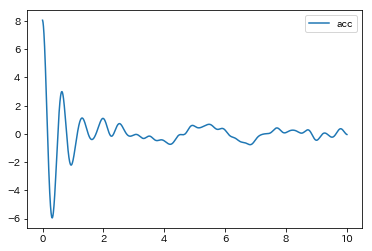

In [34]:
fig, ax = plt.subplots()
tdata = np.arange(0,num*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
ax.plot(tdata,zal,label="acc")
# ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
# ax.plot(xl,zl)

# ax.plot(tdata,xvl,label="vel")

ax.legend()

0.011490719173580745 -0.0034545041585184646
-332.6300576378168


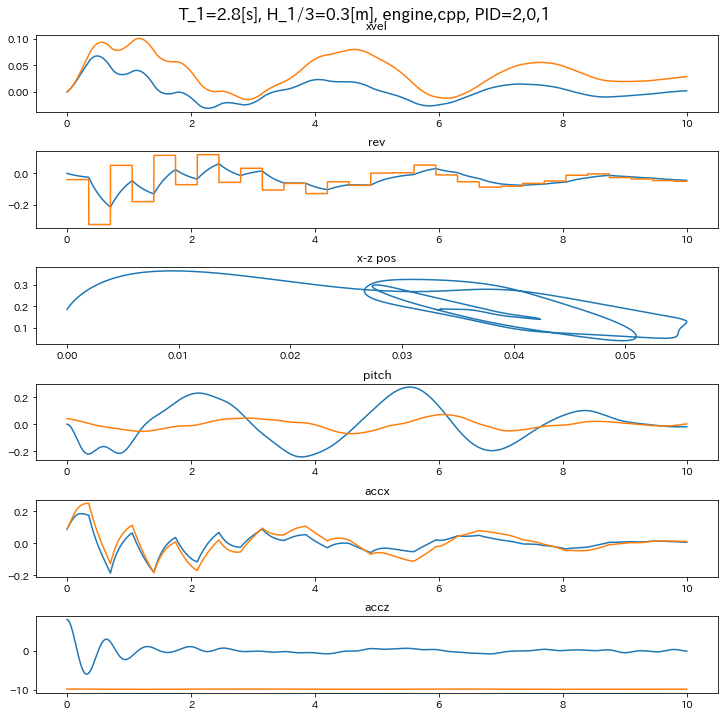

In [35]:
import statistics
xvl_trunc = xvl[-round(len(xvl)/2):]
stdev = statistics.stdev(xvl_trunc)
mean = statistics.mean(xvl_trunc)
cv = stdev/mean*100
print(stdev,mean)
print(cv)


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6,figsize=(10,10),constrained_layout=True)

fig.suptitle( f'T_1={T_1}[s], H_1/3={H_3}[m], {power_type},{prop_type}, PID={P},{I},{D}' , fontsize=16)

ax1.plot(tdata,xvl)
ax1.plot(tdata,xvl_int)
ax1.set_title('xvel')
# ax1.text(1,0.15, f'P Coeff:{P_coeff}')
# ax1.text(1,0.1,f'Coeff of Variance:{cv:.04f}%')

ax2.plot(tdata,prop_pitch)
ax2.plot(tdata,t_prop_pitch)
ax2.set_title('rev')

ax3.plot(xl,zl)
ax3.set_title('x-z pos')

ax4.plot(tdata,pl)
ax4.plot(tdata,wil)
ax4.set_title('pitch')

ax5.plot(tdata,xal)
ax5.plot(tdata,IMU_ax)
ax5.set_title('accx')

ax6.plot(tdata,zal)
ax6.plot(tdata,IMU_az)
ax6.set_title('accz')

fig.savefig("./figures/"+f"{filename}-{time.time()}.png")